In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)
print(x_train_all.shape, y_train_all.shape)

# print(x_train_all[0])

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

# print(x_train_all[0])

word_to_idx = imdb.get_word_index()
print(word_to_idx['movie'])

idx_to_word = {word_to_idx[k]: k for k in word_to_idx}

# for w in x_train_all[0]:
#     print(idx_to_word[w - 3], end=' ')
    
# print(len(x_train_all[0]), len(x_train_all[1]))

# print(y_train_all[:10])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\ghlee\anaconda3\envs\GPUenv\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\ghlee\anaconda3\envs\GPUenv\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is 

(25000,) (25000,)
17


In [3]:
np.random.seed(42)
random_idx = np.random.permutation(25000)

x_train = x_train_all[random_idx[:20000]]
y_train = y_train_all[random_idx[:20000]]
x_val = x_train_all[random_idx[20000:]]
y_val = y_train_all[random_idx[20000:]]

In [4]:
from tensorflow.keras.preprocessing import sequence

maxlen = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

print(x_train_seq.shape, x_val_seq.shape)

print(x_train_seq[0])

(20000, 100) (5000, 100)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [5]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

print(x_train_onehot.shape)
print(x_train_onehot.nbytes)

(20000, 100, 100)
800000000


In [6]:
class RecurrentNetwork:
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells
        self.batch_size = batch_size
        self.w1h = None
        self.w1x = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.h = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
    
    def forpass(self, x):
        # 은닉 상태 초기화
        self.h = [np.zeros((x.shape[0], self.n_cells))]
        # 배치 차원과 타임 스텝 차원 바꾸기
        seq = np.swapaxes(x, 0, 1)
        # 순환층의 선형식 계산
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            # 활성화 함수 적용
            h = np.tanh(z1)
            # 역전파를 위한 은닉 상태 저장
            self.h.append(h)
            # 출력층의 선형식 계산
            z2 = np.dot(h, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m
        # 배치 차원과 타임 스텝 차원 바꾸기
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지 gradient 계산
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        # 모든 타임 스텝을 거슬러가면서 gradient 전파
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 gradient 계산
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
        
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        # 시그모이드 계산
        a = 1 / (1 + np.exp(-z))
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
        self.w1x = glorot_init((n_features, self.n_cells)).numpy()
        self.b1 = np.zeros(self.n_cells)
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        # 은닉층과 출력층의 가중치 초기화
        self.init_weights(x.shape[2], y.shape[1])
        # epoch 만큼 반복
        for i in range(epochs):
            print('epoch', i, end=' ')
            # 제너레이터 함수에서 반환한 미니 배치 순환
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위한 클리핑
                a = np.clip(a, 1e-10, 1 - 1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가
                loss = np.mean(-(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
                
    # 미니 배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        # 미니 배치 횟수
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        idxs = np.random.permutation(np.arange(len(x)))
        x = x[idxs]
        y = y[idxs]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
    
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.sigmoid(z)
        err = -(y - a)
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 셀의 가중치와 절편 업데이트
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def predict(self, x):
        # 정방향 계산
        z = self.forpass(x)
        # 스텝 함수 적용
        return z > 0
    
    def score(self, x, y):
        # 예측과 타깃 열 벡트를 비교하여 True 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def update_val_loss(self, x_val, y_val):
        # 정방향 계산
        z = self.forpass(x_val)
        # 활성화 함수 적용
        a = self.sigmoid(z)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        val_loss = np.mean(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append(val_loss)

In [7]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

epoch 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
epoch 1 ......................................................................................................................................................................................................................................................................................................................................................................

epoch 12 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
epoch 13 ....................................................................................................................................................................................................................................................................................................................................................................

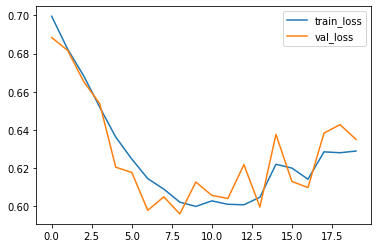

In [8]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [9]:
rn.score(x_val_onehot, y_val)

0.6272